In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")

pd.options.mode.chained_assignment = None

import yfinance as yf

from datetime import datetime, timedelta

import os
os.chdir("/home/backstreet/use_backtest_bolt")

In [3]:
class BacktestBoltBase():
    ''' Base class for iterative backtesting of trading strategies.

    Attributes
    ==========
    symbol: str
        ticker symbol with which to work with
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval
    amount: float
        initial amount to be invested per trade
    tc: float (default = 0)
        transaction costs in bips (0.0001)
    use_feather: boolean (default = True)
        whether to use feather format to load pricing data

    Methods
    =======
    get_data:
        retrieves and prepares the data
    plot_data:
        plots the closing price for the symbol
    get_values:
        returns the date, the price and the spread for the given bar
    print_current_balance:
        prints out the current (cash) balance
    buy_instrument:
        places a buy order
    sell_instrument:
        places a sell order
    print_current_position_value:
        prints out the current position value
    print_current_nav:
        prints out the current net asset value (nav)
    close_pos:
        closes out a long or short position
    '''

    def __init__(self, symbol, start, end, amount, tc = 0, use_feather = True):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.initial_balance = amount
        self.current_balance = amount
        self.units = 0
        self.trades = 0
        self.position = 0
        self.tc = tc * 0.0001
        self.use_feather = use_feather
        self.get_data()

    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        if self.use_feather:
            if not os.path.isfile(f'data/feathers/daily/{self.symbol}.feather'):
                ftr_data = yf.download(self.symbol, start=(datetime.now() - timedelta(days=10 * 365)), end=datetime.today())["Adj Close"].to_frame().dropna().reset_index()
                ftr_data.to_feather(f'data/feathers/daily/{self.symbol}.feather')
            raw = pd.read_feather(f'data/feathers/daily/{self.symbol}.feather')
            raw["Date"] = pd.to_datetime(raw["Date"])
            raw.set_index("Date", inplace=True)
        else:
            if not os.path.isfile(f'data/csvs/daily/{self.symbol}.csv'):
                csv_data = yf.download(self.symbol, start=(datetime.now() - timedelta(days=10 * 365)), end=datetime.today())["Adj Close"]
                csv_data.to_csv(f'data/csvs/daily/{self.symbol}.csv')
            raw = pd.read_csv(f'data/csvs/daily/{self.symbol}.csv')
        raw = raw["Adj Close"].to_frame().dropna()
        raw = raw.loc[self.start:self.end].copy()
        raw.rename(columns={"Adj Close" : "price"}, inplace=True)
        raw = raw.loc[self.start:self.end]
        raw["returns"] = np.log(raw.price / raw.price.shift(1))
        self.data = raw

    def reset_data(self):
        self.position = 0
        self.trades = 0
        self.current_balance = self.initial_balance
        self.get_data()

    def plot_data(self, cols = None, title = None):
        ''' Plots the closing price for the symbol.
        '''
        if cols is None:
            cols = "price"
        if title is None:
            title = self.symbol
        self.data[cols].plot(figsize = (12, 8), title = title)
        plt.show()

    def get_values(self, bar):
        ''' Returns the date, the price and the spread for the given bar.
        '''
        date = str(self.data.index[bar].date())
        price = round(self.data.price.iloc[bar], 5)
        return date, price

    def print_current_balance(self, bar):
        ''' Prints out the current (cash) balance.
        '''
        date, price = self.get_values(bar)
        print("{} | Current Balance: {}".format(date, round(self.current_balance, 2)))

    def buy_instrument(self, bar, units = None, amount = None):
        ''' Places a buy order.
        '''
        date, price = self.get_values(bar)
        price += self.tc
        if amount is not None: # use units if units are passed, otherwise calculate units
            units = int(amount / price)
        self.current_balance -= units * price # reduce cash balance by "purchase price"
        self.units += units
        self.trades += 1
        trade_info = "{} |  Buying {} for {}".format(date, units, round(price, 5))
        print(trade_info)
        self.data["trade_info"].iloc[bar] = trade_info

    def sell_instrument(self, bar, units = None, amount = None):
        ''' Places a sell order.
        '''
        date, price = self.get_values(bar)
        price -= self.tc
        if amount is not None: # use units if units are passed, otherwise calculate units
            units = int(amount / price)
        self.current_balance += units * price # increases cash balance by "purchase price"
        self.units -= units
        self.trades += 1
        trade_info = "{} |  Selling {} for {}".format(date, units, round(price, 5))
        print(trade_info)
        self.data["trade_info"].iloc[bar] = trade_info

    def print_current_position_value(self, bar):
        ''' Prints out the current position value.
        '''
        date, price = self.get_values(bar)
        cpv = self.units * price
        print("{} |  Current Position Value = {}".format(date, round(cpv, 2)))
 
    def print_current_nav(self, bar):
        ''' Prints out the current net asset value (nav).
        '''
        date, price = self.get_values(bar)
        nav = self.current_balance + self.units * price
        print("{} |  Net Asset Value = {}".format(date, round(nav, 2)))

    def update_strategy_returns(self, bar):
        date, price = self.get_values(bar)
        value = self.current_balance + (self.units * price)
        value -= (abs(self.units) * self.tc)
        self.data["strategy_returns"].iloc[bar] = value

    def dump_json(self, fname):
        self.data["Date"] = self.data.index.strftime("%Y%m%d-%H:%M:%S")
        self.data.to_json(f'{self.symbol}_{fname}.json', orient='records')

    def CAGR(self):
        df = self.data.copy()
        n = len(df)/252
        cagr = ((df["cum_return"].to_list()[-1]) ** (1/n)) - 1
        return cagr

    def volatility(self):
        df = self.data.copy()
        vol = df["daily_ret"].std() * np.sqrt(252)
        return vol

    def max_dd(self):
        df = self.data.copy()
        df["cum_roll_max"] = df["cum_return"].cummax()
        df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
        df["drawdown_pct"] = df["drawdown"] / df["cum_roll_max"]
        max_dd = df["drawdown_pct"].max()
        return max_dd
        
    def perf_analysis(self, bar, title=None):
        date, price = self.get_values(bar)
        perf = (self.current_balance - self.initial_balance) / self.initial_balance * 100
        self.print_current_balance(bar)
        print("{} | Net performance (%) = {}".format(date, round(perf, 2) ))

        # KPIs
        self.data["daily_ret"] = self.data["strategy_returns"].pct_change()
        self.data["cum_return"] = (1 + self.data["daily_ret"]).cumprod()

        cagr = self.CAGR() * 100
        print("{} | Compounded Annual Growth Rate (%) = {}".format(date, cagr))

        vol = self.volatility() * 100
        print("{} | Annualized Volatility (%) = {}".format(date, vol))

        sharpe = cagr / vol
        print("{} | Sharpe Ratio = {}".format(date, sharpe))

        mdd = self.max_dd() * 100
        print("{} | Maximum Drawdown (%) = {}".format(date, mdd))

        self.data["benchmark_buy_and_hold"] = self.data["returns"].cumsum().apply(np.exp) * self.initial_balance
        self.plot_data(cols=["benchmark_buy_and_hold", "strategy_returns"], title=title)
        print(75 * "-")

    def close_pos(self, bar):
        ''' Closes out a long or short position.
        '''
        date, price = self.get_values(bar)
        print(75 * "-")
        print("{} | +++ CLOSING FINAL POSITION +++".format(date))
        self.current_balance += self.units * price # closing final position (works with short and long!)
        self.current_balance -= (abs(self.units) * self.tc) # substract transactions costs
        self.data["strategy_returns"].iloc[bar] = self.current_balance
        print("{} | closing position of {} for {}".format(date, self.units, price))
        self.units = 0 # setting position to neutral
        self.trades += 1
        print("{} | number of trades executed = {}".format(date, self.trades))

       

In [4]:
class SingleStockStrategies(BacktestBoltBase):
    ''' Class for iterative backtesting of trading strategies.

    Attributes
    ==========
    symbol: str
        ticker symbol with which to work with
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval
    amount: float
        initial amount to be invested per trade

    Methods
    =======
    test_sma_strategy:
        test an sma strategy with SMA_S (short) and SMA_L (long)
    test_con_strategy:
        test a contrarian strategy
    test_boll_strategy:
        test a mean-reversion strategy (bollinger) with SMA and dist

    '''

    # helper method
    def go_long(self, bar, units = None, amount = None):
        if self.position == -1:
            self.buy_instrument(bar, units = -self.units) # if short position, go neutral first
        if units:
            self.buy_instrument(bar, units = units)
        elif amount:
            if amount == "all":
                amount = self.current_balance
            self.buy_instrument(bar, amount = amount) # go long

    # helper method
    def go_short(self, bar, units = None, amount = None):
        if self.position == 1:
            self.sell_instrument(bar, units = self.units) # if long position, go neutral first
        if units:
            self.sell_instrument(bar, units = units)
        elif amount:
            if amount == "all":
                amount = self.current_balance
            self.sell_instrument(bar, amount = amount) # go short

    def test_sma_strategy(self, SMA_S, SMA_L):
        ''' Test an sma strategy with SMA_S (short) and SMA_L (long).
        '''

        # nice printout
        stm = "Testing SMA strategy | {} | SMA_S = {} & SMA_L = {}".format(self.symbol, SMA_S, SMA_L)
        print("-" * 75)
        print(stm)
        print("-" * 75)

        # reset
        self.reset_data() # reset dataset

        # prepare data
        self.data["SMA_S"] = self.data["price"].rolling(SMA_S).mean()
        self.data["SMA_L"] = self.data["price"].rolling(SMA_L).mean()
        self.data.dropna(inplace = True)
        self.data["strategy_returns"] = 0
        self.data["trade_info"] = ""
        bar = 0

        # sma crossover strategy
        for bar in range(len(self.data)-1): # all bars (except the last bar)
            if self.data["SMA_S"].iloc[bar] > self.data["SMA_L"].iloc[bar]: # signal to go long
                if self.position in [0, -1]:
                    self.go_long(bar, amount = "all") # go long with full amount
                    self.position = 1  # long position
            elif self.data["SMA_S"].iloc[bar] < self.data["SMA_L"].iloc[bar]: # signal to go short
                if self.position in [0, 1]:
                    self.go_short(bar, amount = "all") # go short with full amount
                    self.position = -1 # short position
            self.update_strategy_returns(bar)
        if bar > 0:
            self.close_pos(bar+1) # close position at the last bar
            self.perf_analysis(bar + 1, stm)
        # self.dump_json("sma")

    def test_con_strategy(self, window = 1):
        ''' Test a contrarian strategy.
        '''

        # nice printout
        stm = "Testing Contrarian strategy | {} | Window = {}".format(self.symbol, window)
        print("-" * 75)
        print(stm)
        print("-" * 75)

        # reset
        self.reset_data() # reset dataset

        # prepare data
        self.data["rolling_returns"] = self.data["returns"].rolling(window).mean()
        self.data.dropna(inplace = True)
        self.data["strategy_returns"] = 0
        self.data["trade_info"] = ""
        bar = 0

        # Contrarian strategy
        for bar in range(len(self.data)-1): # all bars (except the last bar)
            if self.data["rolling_returns"].iloc[bar] <= 0: #signal to go long
                if self.position in [0, -1]:
                    self.go_long(bar, amount = "all") # go long with full amount
                    self.position = 1  # long position
            elif self.data["rolling_returns"].iloc[bar] > 0: #signal to go short
                if self.position in [0, 1]:
                    self.go_short(bar, amount = "all") # go short with full amount
                    self.position = -1 # short position
            self.update_strategy_returns(bar)
        if bar > 0:
            self.close_pos(bar+1) # close position at the last bar
            self.perf_analysis(bar + 1, stm)
        # self.dump_json("contrarian")

    def test_boll_strategy(self, SMA, dev):
        ''' Test a mean-reversion strategy (bollinger) with SMA and dev.
        '''

        # nice printout
        stm = "Testing Bollinger Bands Strategy | {} | SMA = {} & dev = {}".format(self.symbol, SMA, dev)
        print("-" * 75)
        print(stm)
        print("-" * 75)

        # reset
        self.reset_data() # reset dataset

        # prepare data
        self.data["SMA"] = self.data["price"].rolling(SMA).mean()
        self.data["Lower"] = self.data["SMA"] - self.data["price"].rolling(SMA).std() * dev
        self.data["Upper"] = self.data["SMA"] + self.data["price"].rolling(SMA).std() * dev
        self.data.dropna(inplace = True)
        self.data["strategy_returns"] = 0
        self.data["trade_info"] = ""
        bar = 0

        # Bollinger strategy
        for bar in range(len(self.data)-1): # all bars (except the last bar)
            if self.position == 0: # when neutral
                if self.data["price"].iloc[bar] < self.data["Lower"].iloc[bar]: # signal to go long
                    self.go_long(bar, amount = "all") # go long with full amount
                    self.position = 1  # long position
                elif self.data["price"].iloc[bar] > self.data["Upper"].iloc[bar]: # signal to go Short
                    self.go_short(bar, amount = "all") # go short with full amount
                    self.position = -1 # short position
            elif self.position == 1: # when long
                if self.data["price"].iloc[bar] > self.data["SMA"].iloc[bar]:
                    if self.data["price"].iloc[bar] > self.data["Upper"].iloc[bar]: # signal to go short
                        self.go_short(bar, amount = "all") # go short with full amount
                        self.position = -1 # short position
                    else:
                        self.sell_instrument(bar, units = self.units) # go neutral
                        self.position = 0
            elif self.position == -1: # when short
                if self.data["price"].iloc[bar] < self.data["SMA"].iloc[bar]:
                    if self.data["price"].iloc[bar] < self.data["Lower"].iloc[bar]: # signal to go long
                        self.go_long(bar, amount = "all") # go long with full amount
                        self.position = 1 # long position
                    else:
                        self.buy_instrument(bar, units = -self.units) # go neutral
                        self.position = 0
            self.update_strategy_returns(bar)
        if bar > 0:
            self.close_pos(bar+1) # close position at the last bar
            self.perf_analysis(bar + 1, stm)
        # self.dump_json("bollinger")



In [5]:
def single_stock_backtest(stock, start, end, amount, strategy):
    tester = SingleStockStrategies(stock, start, end, amount)
    if strategy == "sma":
        tester.test_sma_strategy(50, 200)
    elif strategy == "con":
        tester.test_con_strategy(3)
    elif strategy == "boll":
        tester.test_boll_strategy(50, 3)


---------------------------------------------------------------------------
Testing SMA strategy | 600276.SS | SMA_S = 50 & SMA_L = 200
---------------------------------------------------------------------------
2012-10-31 |  Buying 1438 for 6.95181
2014-05-07 |  Selling 1438 for 8.53452
2014-05-07 |  Selling 1438 for 8.53452
2014-06-18 |  Buying 1438 for 9.39295
2014-06-18 |  Buying 1175 for 9.39295
2016-02-25 |  Selling 1175 for 16.7298
2016-02-25 |  Selling 1175 for 16.7298
2016-05-12 |  Buying 1175 for 17.19147
2016-05-12 |  Buying 1112 for 17.19147
2016-05-18 |  Selling 1112 for 17.27941
2016-05-18 |  Selling 1112 for 17.27941
2016-07-22 |  Buying 1112 for 18.55947
2016-07-22 |  Buying 958 for 18.55947
2018-10-11 |  Selling 958 for 38.36999
2018-10-11 |  Selling 958 for 38.36999
2019-03-27 |  Buying 958 for 51.3626
2019-03-27 |  Buying 473 for 51.3626
---------------------------------------------------------------------------
2021-01-29 | +++ CLOSING FINAL POSITION +++
2021-01-29 

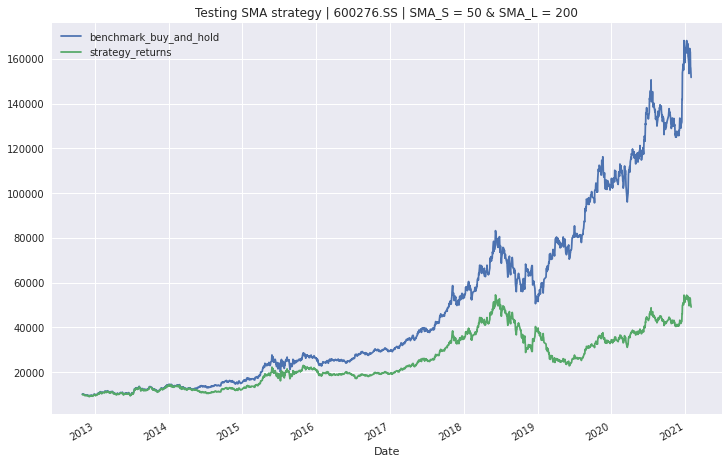

---------------------------------------------------------------------------
---------------------------------------------------------------------------
Testing Contrarian strategy | 600276.SS | Window = 3
---------------------------------------------------------------------------
2012-01-09 |  Buying 1740 for 5.74395
2012-01-10 |  Selling 1740 for 5.81733
2012-01-10 |  Selling 1740 for 5.81733
2012-01-12 |  Buying 1740 for 5.73766
2012-01-12 |  Buying 1789 for 5.73766
2012-01-20 |  Selling 1789 for 5.59302
2012-01-20 |  Selling 1789 for 5.59302
2012-02-01 |  Buying 1789 for 5.42112
2012-02-01 |  Buying 1902 for 5.42112
2012-02-02 |  Selling 1902 for 5.50078
2012-02-02 |  Selling 1902 for 5.50078
2012-02-09 |  Buying 1902 for 5.64543
2012-02-09 |  Buying 1805 for 5.64543
2012-02-10 |  Selling 1805 for 5.58254
2012-02-10 |  Selling 1805 for 5.58254
2012-02-14 |  Buying 1805 for 5.63285
2012-02-14 |  Buying 1773 for 5.63285
2012-02-15 |  Selling 1773 for 5.69574
2012-02-15 |  Selling 1773

2014-07-14 |  Selling 1774 for 9.1003
2014-07-14 |  Selling 1774 for 9.1003
2014-07-16 |  Buying 1774 for 8.90051
2014-07-16 |  Buying 1853 for 8.90051
2014-07-21 |  Selling 1853 for 9.07779
2014-07-21 |  Selling 1853 for 9.07779
2014-07-25 |  Buying 1853 for 9.08623
2014-07-25 |  Buying 1850 for 9.08623
2014-07-28 |  Selling 1850 for 9.1003
2014-07-28 |  Selling 1850 for 9.1003
2014-08-06 |  Buying 1850 for 9.34512
2014-08-06 |  Buying 1753 for 9.34512
2014-08-11 |  Selling 1753 for 9.44923
2014-08-11 |  Selling 1753 for 9.44923
2014-08-14 |  Buying 1753 for 9.44642
2014-08-14 |  Buying 1754 for 9.44642
2014-08-15 |  Selling 1754 for 9.604
2014-08-15 |  Selling 1754 for 9.604
2014-08-21 |  Buying 1754 for 9.7053
2014-08-21 |  Buying 1717 for 9.7053
2014-08-25 |  Selling 1717 for 9.65465
2014-08-25 |  Selling 1717 for 9.65465
2014-08-26 |  Buying 1717 for 9.69686
2014-08-26 |  Buying 1702 for 9.69686
2014-09-01 |  Selling 1702 for 9.59274
2014-09-01 |  Selling 1702 for 9.59274
2014-09-

2016-04-14 |  Selling 3380 for 17.30139
2016-04-14 |  Selling 3380 for 17.30139
2016-04-21 |  Buying 3380 for 17.12552
2016-04-21 |  Buying 3449 for 17.12552
2016-04-26 |  Selling 3449 for 17.34536
2016-04-26 |  Selling 3449 for 17.34536
2016-04-29 |  Buying 3449 for 17.10353
2016-04-29 |  Buying 3547 for 17.10353
2016-05-03 |  Selling 3547 for 17.51024
2016-05-03 |  Selling 3547 for 17.51024
2016-05-06 |  Buying 3547 for 17.19147
2016-05-06 |  Buying 3679 for 17.19147
2016-05-11 |  Selling 3679 for 17.31604
2016-05-11 |  Selling 3679 for 17.31604
2016-05-16 |  Buying 3679 for 17.22444
2016-05-16 |  Buying 3718 for 17.22444
2016-05-17 |  Selling 3718 for 17.34902
2016-05-17 |  Selling 3718 for 17.34902
2016-05-19 |  Buying 3718 for 17.08521
2016-05-19 |  Buying 3832 for 17.08521
2016-05-31 |  Selling 3832 for 16.8324
2016-05-31 |  Selling 3832 for 16.8324
2016-06-08 |  Buying 3832 for 17.10719
2016-06-08 |  Buying 3709 for 17.10719
2016-06-16 |  Selling 3709 for 17.14504
2016-06-16 |  

2018-05-17 |  Buying 2305 for 47.66064
2018-05-17 |  Buying 2027 for 47.66064
2018-05-21 |  Selling 2027 for 48.64109
2018-05-21 |  Selling 2027 for 48.64109
2018-05-30 |  Buying 2027 for 51.47312
2018-05-30 |  Buying 1804 for 51.47312
2018-06-01 |  Selling 1804 for 51.12085
2018-06-01 |  Selling 1804 for 51.12085
2018-06-11 |  Buying 1804 for 53.89067
2018-06-11 |  Buying 1618 for 53.89067
2018-06-20 |  Selling 1618 for 54.52614
2018-06-20 |  Selling 1618 for 54.52614
2018-06-27 |  Buying 1618 for 52.80622
2018-06-27 |  Buying 1724 for 52.80622
2018-07-09 |  Selling 1724 for 49.9328
2018-07-09 |  Selling 1724 for 49.9328
2018-07-17 |  Buying 1724 for 50.25053
2018-07-17 |  Buying 1702 for 50.25053
2018-07-20 |  Selling 1702 for 50.94817
2018-07-20 |  Selling 1702 for 50.94817
2018-07-23 |  Buying 1702 for 48.48226
2018-07-23 |  Buying 1875 for 48.48226
2018-07-26 |  Selling 1875 for 48.69639
2018-07-26 |  Selling 1875 for 48.69639
2018-07-27 |  Buying 1875 for 48.62732
2018-07-27 |  B

2019-12-23 |  Selling 1855 for 70.85462
2019-12-24 |  Buying 1855 for 70.24774
2019-12-24 |  Buying 1887 for 70.24774
2019-12-30 |  Selling 1887 for 71.07908
2019-12-30 |  Selling 1887 for 71.07908
2020-01-06 |  Buying 1887 for 69.9069
2020-01-06 |  Buying 1950 for 69.9069
2020-01-09 |  Selling 1950 for 72.22633
2020-01-09 |  Selling 1950 for 72.22633
2020-01-14 |  Buying 1950 for 71.91873
2020-01-14 |  Buying 1967 for 71.91873
2020-01-17 |  Selling 1967 for 75.36877
2020-01-17 |  Selling 1967 for 75.36877
2020-01-22 |  Buying 1967 for 75.09443
2020-01-22 |  Buying 1981 for 75.09443
2020-02-05 |  Selling 1981 for 73.91393
2020-02-05 |  Selling 1981 for 73.91393
2020-02-10 |  Buying 1981 for 73.57308
2020-02-10 |  Buying 2000 for 73.57308
2020-02-11 |  Selling 2000 for 74.94479
2020-02-11 |  Selling 2000 for 74.94479
2020-02-17 |  Buying 2000 for 76.79866
2020-02-17 |  Buying 1903 for 76.79866
2020-03-03 |  Selling 1903 for 73.44007
2020-03-03 |  Selling 1903 for 73.44007
2020-03-10 |  

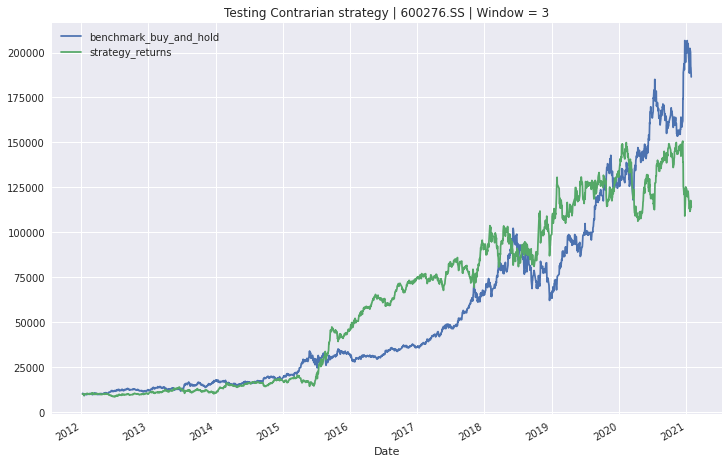

---------------------------------------------------------------------------
---------------------------------------------------------------------------
Testing Bollinger Bands Strategy | 600276.SS | SMA = 50 & dev = 3
---------------------------------------------------------------------------
2013-07-15 |  Selling 1205 for 8.29468
2013-09-02 |  Buying 1205 for 8.12374
2014-09-19 |  Selling 978 for 10.43411
2014-11-20 |  Buying 978 for 10.47914
2015-04-01 |  Selling 745 for 13.6392
2015-06-16 |  Buying 745 for 16.01533
2016-01-07 |  Buying 495 for 16.924
2016-02-24 |  Selling 495 for 17.20246
2016-05-25 |  Buying 514 for 16.57225
2016-06-16 |  Selling 514 for 17.14504
2016-07-12 |  Selling 463 for 19.05739
2016-09-09 |  Buying 463 for 19.03535
2016-10-17 |  Selling 428 for 20.63926
2016-12-20 |  Buying 428 for 20.21625
2017-02-03 |  Selling 418 for 21.54256
2017-07-13 |  Buying 418 for 26.02176
2017-08-09 |  Selling 254 for 28.05687
2017-11-27 |  Buying 254 for 34.04028
2018-03-19 |  Se

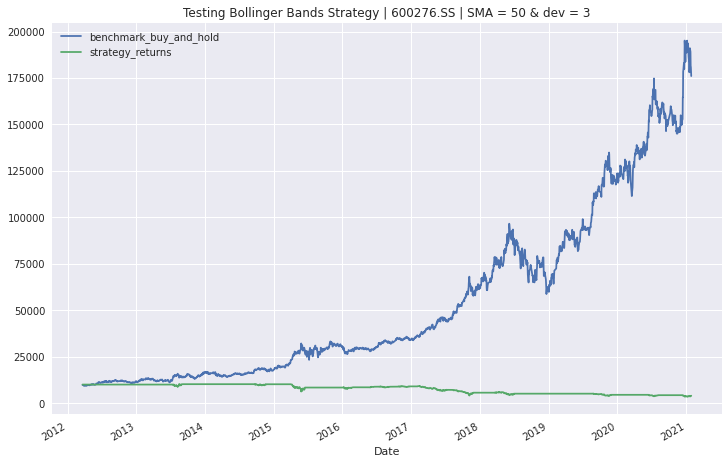

---------------------------------------------------------------------------
---------------------------------------------------------------------------
Testing SMA strategy | F | SMA_S = 50 & SMA_L = 200
---------------------------------------------------------------------------
2012-10-16 |  Selling 1412 for 7.07815
2012-12-05 |  Buying 1412 for 7.80992
2012-12-05 |  Buying 1148 for 7.80992
2014-02-04 |  Selling 1148 for 10.62554
2014-02-04 |  Selling 1148 for 10.62554
2014-06-11 |  Buying 1148 for 12.17048
2014-06-11 |  Buying 856 for 12.17048
2014-10-22 |  Selling 856 for 10.24858
2014-10-22 |  Selling 856 for 10.24858
2015-03-20 |  Buying 856 for 12.18256
2015-03-20 |  Buying 584 for 12.18256
2015-07-20 |  Selling 584 for 10.87217
2015-07-20 |  Selling 584 for 10.87217
2016-05-10 |  Buying 584 for 10.7362
2016-05-10 |  Buying 599 for 10.7362
2016-08-18 |  Selling 599 for 9.9206
2016-08-18 |  Selling 599 for 9.9206
2017-01-30 |  Buying 599 for 10.23918
2017-01-30 |  Buying 562 for 1

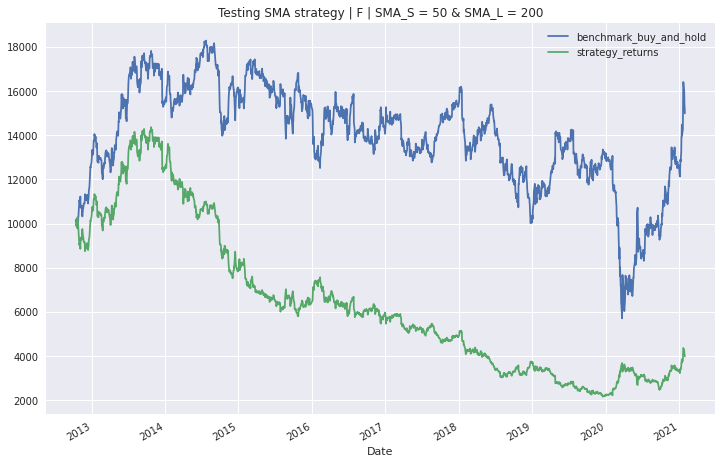

---------------------------------------------------------------------------
---------------------------------------------------------------------------
Testing Contrarian strategy | F | Window = 3
---------------------------------------------------------------------------
2012-01-06 |  Selling 1259 for 7.9379
2012-01-17 |  Buying 1259 for 8.14805
2012-01-17 |  Buying 1194 for 8.14805
2012-01-18 |  Selling 1194 for 8.36497
2012-01-18 |  Selling 1194 for 8.36497
2012-01-27 |  Buying 1194 for 8.30933
2012-01-27 |  Buying 1210 for 8.30933
2012-02-01 |  Selling 1210 for 8.39099
2012-02-01 |  Selling 1210 for 8.39099
2012-02-02 |  Buying 1210 for 8.34336
2012-02-02 |  Buying 1224 for 8.34336
2012-02-03 |  Selling 1224 for 8.70404
2012-02-03 |  Selling 1224 for 8.70404
2012-02-09 |  Buying 1224 for 8.63598
2012-02-09 |  Buying 1243 for 8.63598
2012-02-16 |  Selling 1243 for 8.67001
2012-02-16 |  Selling 1243 for 8.67001
2012-02-22 |  Buying 1243 for 8.35697
2012-02-22 |  Buying 1337 for 8.356

2014-02-21 |  Buying 573 for 10.83276
2014-02-21 |  Buying 549 for 10.83276
2014-02-26 |  Selling 549 for 10.90422
2014-02-26 |  Selling 549 for 10.90422
2014-03-03 |  Buying 549 for 10.86134
2014-03-03 |  Buying 554 for 10.86134
2014-03-05 |  Selling 554 for 11.16861
2014-03-05 |  Selling 554 for 11.16861
2014-03-10 |  Buying 554 for 11.08286
2014-03-10 |  Buying 562 for 11.08286
2014-03-18 |  Selling 562 for 11.06857
2014-03-18 |  Selling 562 for 11.06857
2014-03-21 |  Buying 562 for 11.05428
2014-03-21 |  Buying 564 for 11.05428
2014-03-28 |  Selling 564 for 11.03998
2014-03-28 |  Selling 564 for 11.03998
2014-04-04 |  Buying 564 for 11.52588
2014-04-04 |  Buying 516 for 11.52588
2014-04-15 |  Selling 516 for 11.31866
2014-04-15 |  Selling 516 for 11.31866
2014-04-25 |  Buying 516 for 11.27579
2014-04-25 |  Buying 520 for 11.27579
2014-04-30 |  Selling 520 for 11.63036
2014-04-30 |  Selling 520 for 11.63036
2014-05-02 |  Buying 520 for 11.45033
2014-05-02 |  Buying 536 for 11.45033


2018-03-19 |  Buying 522 for 9.70428
2018-03-27 |  Selling 522 for 9.54563
2018-03-27 |  Selling 522 for 9.54563
2018-04-09 |  Buying 522 for 9.91582
2018-04-09 |  Buying 483 for 9.91582
2018-04-10 |  Selling 483 for 10.0921
2018-04-10 |  Selling 483 for 10.0921
2018-04-13 |  Buying 483 for 9.94226
2018-04-13 |  Buying 498 for 9.94226
2018-04-17 |  Selling 498 for 10.0304
2018-04-17 |  Selling 498 for 10.0304
2018-04-19 |  Buying 498 for 9.78982
2018-04-19 |  Buying 522 for 9.78982
2018-04-25 |  Selling 522 for 9.92381
2018-04-25 |  Selling 522 for 9.92381
2018-05-01 |  Buying 522 for 10.05779
2018-05-01 |  Buying 508 for 10.05779
2018-05-04 |  Selling 508 for 10.14711
2018-05-04 |  Selling 508 for 10.14711
2018-05-09 |  Buying 508 for 9.87915
2018-05-09 |  Buying 536 for 9.87915
2018-05-14 |  Selling 536 for 9.98633
2018-05-14 |  Selling 536 for 9.98633
2018-05-25 |  Buying 536 for 10.2811
2018-05-25 |  Buying 505 for 10.2811
2018-05-29 |  Selling 505 for 10.21857
2018-05-29 |  Sellin

2019-10-08 |  Buying 637 for 8.26161
2019-10-11 |  Selling 637 for 8.49378
2019-10-11 |  Selling 637 for 8.49378
2019-10-24 |  Buying 637 for 8.45619
2019-10-24 |  Buying 643 for 8.45619
2019-10-29 |  Selling 643 for 8.49552
2019-10-29 |  Selling 643 for 8.49552
2019-10-30 |  Buying 643 for 8.39719
2019-10-30 |  Buying 658 for 8.39719
2019-11-01 |  Selling 658 for 8.74134
2019-11-01 |  Selling 658 for 8.74134
2019-11-07 |  Buying 658 for 8.74134
2019-11-07 |  Buying 658 for 8.74134
2019-11-08 |  Selling 658 for 8.88883
2019-11-08 |  Selling 658 for 8.88883
2019-11-13 |  Buying 658 for 8.66268
2019-11-13 |  Buying 692 for 8.66268
2019-11-18 |  Selling 692 for 8.80033
2019-11-18 |  Selling 692 for 8.80033
2019-11-20 |  Buying 692 for 8.58401
2019-11-20 |  Buying 727 for 8.58401
2019-11-25 |  Selling 727 for 8.8495
2019-11-25 |  Selling 727 for 8.8495
2019-12-03 |  Buying 727 for 8.74134
2019-12-03 |  Buying 745 for 8.74134
2019-12-06 |  Selling 745 for 8.86916
2019-12-06 |  Selling 745 f

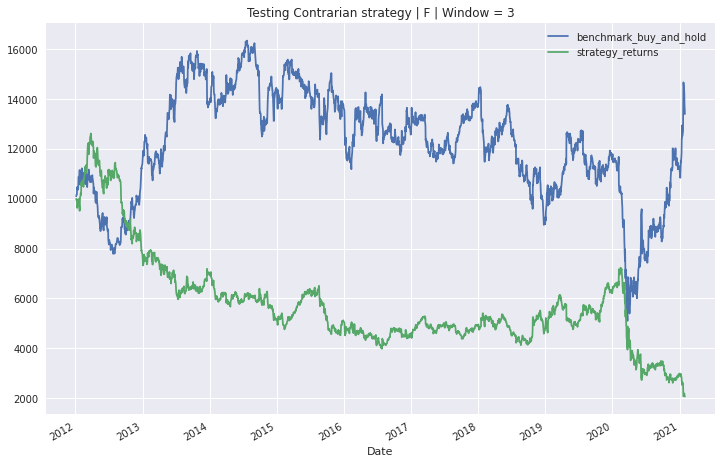

---------------------------------------------------------------------------
---------------------------------------------------------------------------
Testing Bollinger Bands Strategy | F | SMA = 50 & dev = 3
---------------------------------------------------------------------------
2012-04-10 |  Buying 1246 for 8.0235
2012-08-16 |  Selling 1246 for 6.59024
2012-09-07 |  Selling 1178 for 6.9682
2013-02-20 |  Buying 1178 for 8.76477
2013-12-18 |  Buying 549 for 11.09397
2014-01-14 |  Selling 549 for 11.62564
2014-09-29 |  Buying 583 for 10.95938
2014-11-13 |  Selling 583 for 10.92527
2015-08-24 |  Buying 640 for 9.94298
2015-09-15 |  Selling 640 for 10.78727
2016-01-07 |  Buying 714 for 9.67103
2016-02-22 |  Selling 714 for 9.887
2016-06-24 |  Buying 708 for 9.96421
2016-07-11 |  Selling 708 for 10.56111
2016-12-07 |  Selling 703 for 10.63886
2016-12-30 |  Buying 703 for 9.88127
2017-03-21 |  Buying 826 for 9.70114
2017-06-01 |  Selling 826 for 9.57183
2018-02-05 |  Buying 876 for 9.0

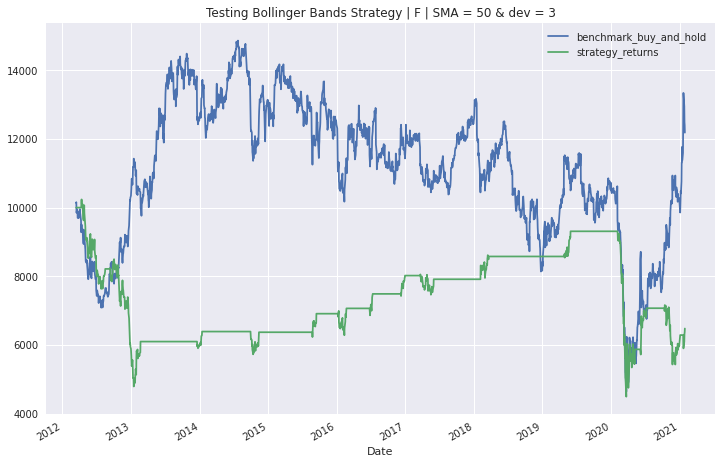

---------------------------------------------------------------------------


In [6]:
stocks = ["600276.SS", "F"]
strategies = ["sma", "con", "boll"]
start = "2012-01-01"
end = "2021-01-30"
init_balance = 10000

for stock in stocks:
    for strategy in strategies:
        single_stock_backtest(stock, start, end, init_balance, strategy)
